### Setup

In [15]:
!pip install kaleido

In [16]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueLinearModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px


matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [3]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Compute Spike Stats

In [4]:
temp_units = spike_utils.get_temporal_drive_unit_ids(fs, subject, session)
ant_units = spike_utils.get_anterior_drive_unit_ids(fs, subject, session)

temp_then_ant = np.concatenate((temp_units, ant_units))

# get spike count variances per unit
unit_stats = spike_utils.get_stats_for_units(firing_rates)
spike_count_vars = unit_stats.SpikeCountVar
spike_count_vars = spike_count_vars[:, None]

spike_count_means = unit_stats.SpikeCountMean[:, None]


/tmp/ipykernel_1060591/3062331070.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_vars = spike_count_vars[:, None]
/tmp/ipykernel_1060591/3062331070.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_means = unit_stats.SpikeCountMean[:, None]


### Look at Weights

(28,)


Text(0.5, 1.0, 'Choice Decoders (Value Model) Weights Across Timebins')

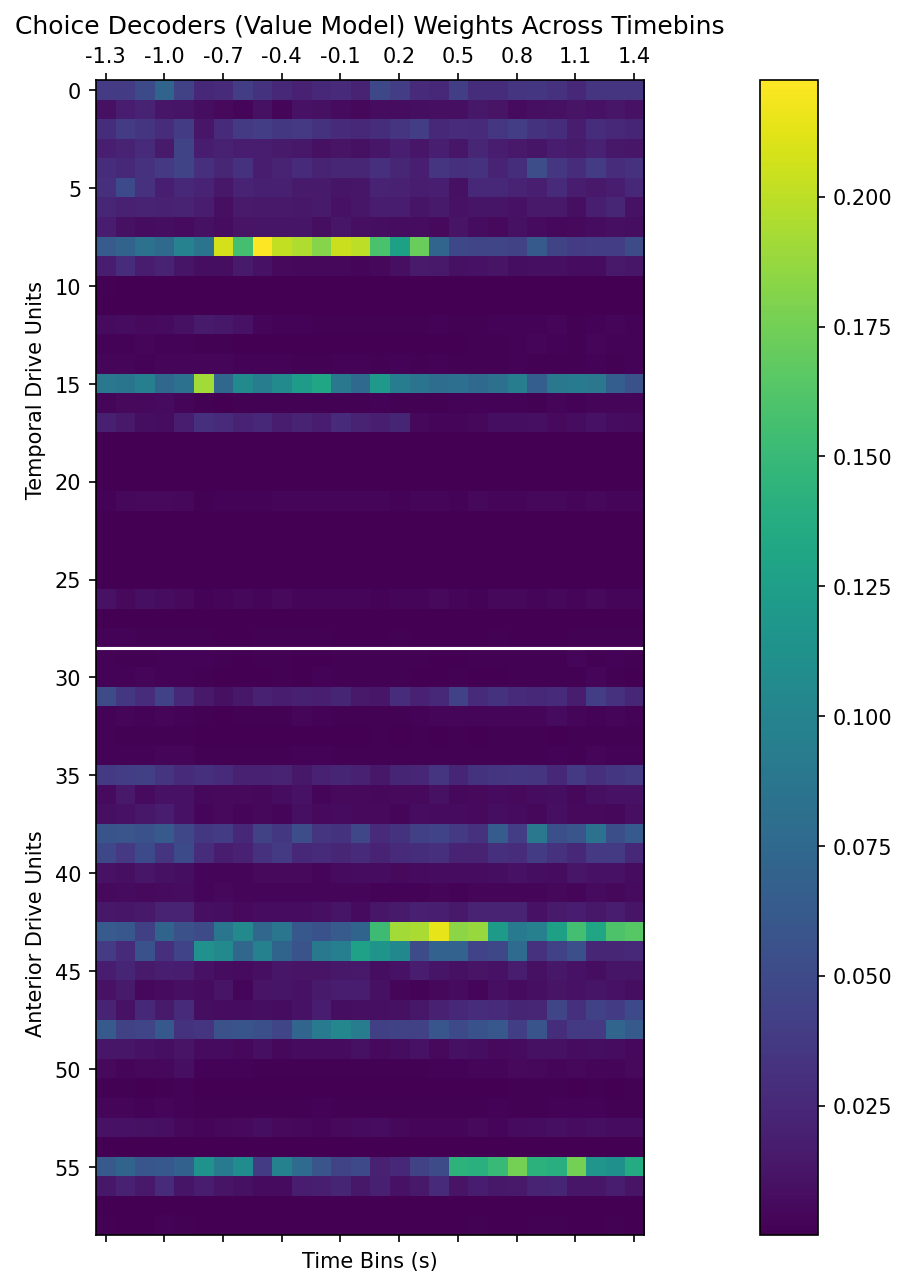

In [34]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
models = np.load(fs.open(f"l2l.pqz317.scratch/value_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)
var_accounted = weights * spike_count_vars

sums = np.sum(var_accounted, axis=0)
print(sums.shape)

normalized = var_accounted / sums
# reorder by temp then ant
reordered = normalized[temp_then_ant, :]

fig, ax = plt.subplots(figsize=(20, 10))
colors = ax.matshow(reordered)
fig.colorbar(colors)
axis = np.arange(0, 28, 3)
labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(axis)
ax.set_xticklabels(labels)
ax.set_xlabel("Time Bins (s)")
y_axis = np.arange(0, 59, 5)
ax.set_ylabel("Anterior Drive Units                                                  Temporal Drive Units")
ax.set_yticks(y_axis)
ax.set_yticklabels(y_axis)
ax.axhline(len(temp_units) - 0.5, color='white')

ax.set_title(f"Choice Decoders (Value Model) Weights Across Timebins") 

In [20]:
weights_df = classifier_utils.convert_model_weights_to_df(normalized, -1300, 100)

units = spike_general.list_session_units(fs, subject, session)
electrode_pos = lfp_development.get_electrode_xyz(fs, "nhp", subject, "WCST", str(session), chans_spc="all")

unit_pos = pd.merge(units, electrode_pos, left_on="Channel", right_on="ch", how="left")
unit_pos = unit_pos.astype({"UnitID": int})
weights_pos = pd.merge(weights_df, unit_pos, on="UnitID")
weights_pos["AntDrive"] = weights_pos.ch.str.contains('a')

59


In [21]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == -700]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)
fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.2
    },
    title_text="Neuron contributions to decodability 700ms before Feedback event"

)
fig.write_html(fs.open(f"l2l.pqz317.scratch/vis_weight_pos_negative_700.html", "w"))

In [22]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == 500]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)

fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.2
    },
    title_text="Neuron contributions to decodability 500ms after Feedback event"
)
fig.write_html(fs.open(f"l2l.pqz317.scratch/vis_weight_pos_500.html", "w"))

In [23]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == 300]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)

fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.2
    },
    title_text="Neuron contributions to decodability 300ms after Feedback event"
)
fig.write_html(fs.open(f"l2l.pqz317.scratch/vis_weight_pos_300.html", "w"))

### Look at weights for normalized model

(28,)


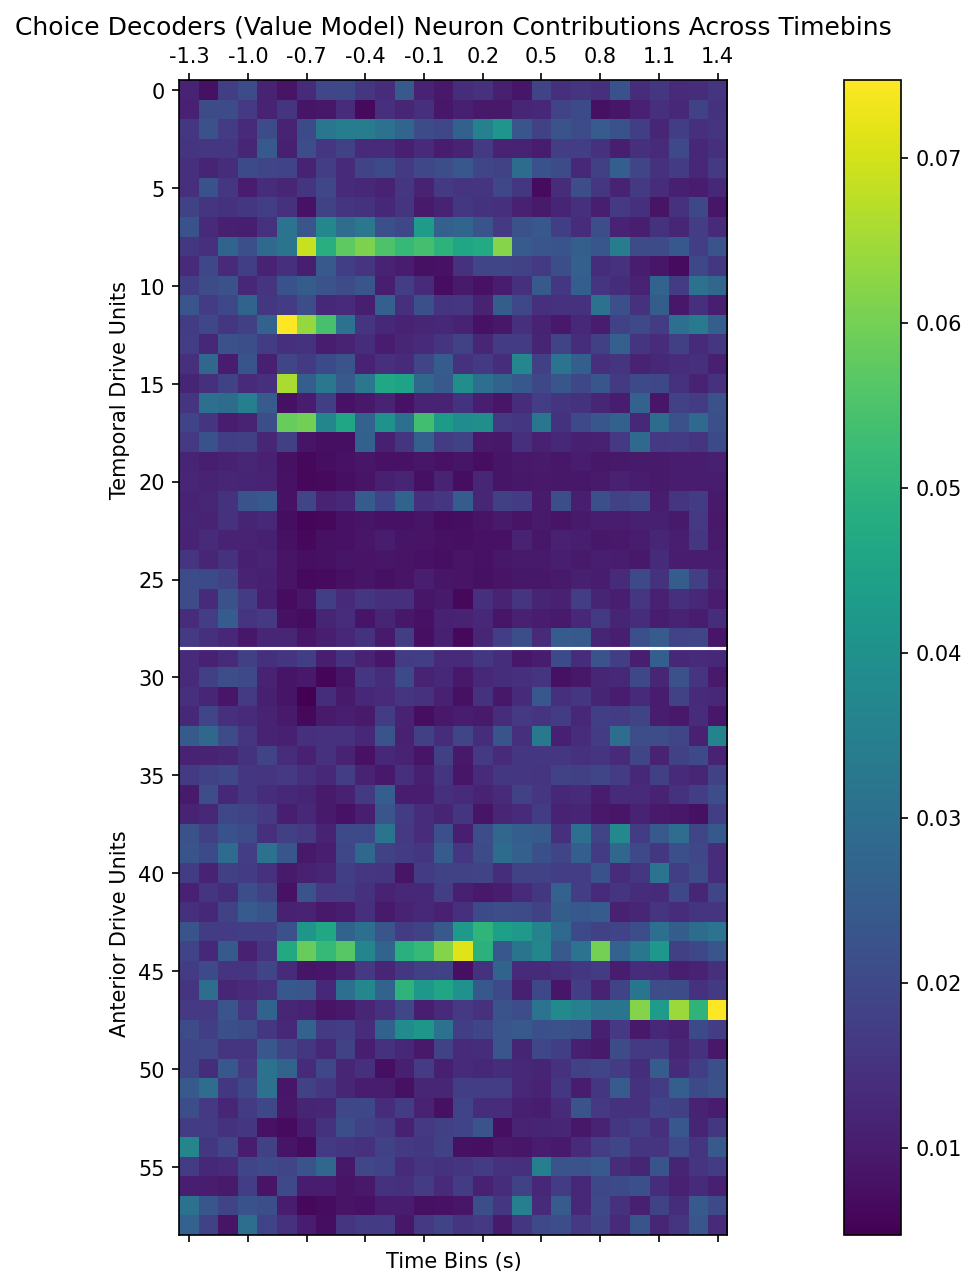

In [7]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
models = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)

sums = np.sum(weights, axis=0)
print(sums.shape)

normalized = weights / sums
# reorder by temp then ant
reordered = normalized[temp_then_ant, :]

fig, ax = plt.subplots(figsize=(20, 10))
colors = ax.matshow(reordered)
fig.colorbar(colors)
axis = np.arange(0, 28, 3)
labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(axis)
ax.set_xticklabels(labels)
ax.set_xlabel("Time Bins (s)")
y_axis = np.arange(0, 59, 5)
ax.set_ylabel("Anterior Drive Units                                                  Temporal Drive Units")
ax.set_yticks(y_axis)
ax.set_yticklabels(y_axis)
ax.axhline(len(temp_units) - 0.5, color='white')

ax.set_title(f"Choice Decoders (Value Model) Neuron Contributions Across Timebins") 
fig.savefig("../data/value_normed_model_weights_by_time.pdf")


In [43]:
np.sum(weights_pos[weights_pos.TimeBin == -700].Weight)

1.0

In [8]:
weights_df = classifier_utils.convert_model_weights_to_df(normalized, -1300, 100)

units = spike_general.list_session_units(fs, subject, session)
electrode_pos = lfp_development.get_electrode_xyz(fs, "nhp", subject, "WCST", str(session), chans_spc="all")

unit_pos = pd.merge(units, electrode_pos, left_on="Channel", right_on="ch", how="left")
unit_pos = unit_pos.astype({"UnitID": int})
weights_pos = pd.merge(weights_df, unit_pos, on="UnitID")
weights_pos["AntDrive"] = weights_pos.ch.str.contains('a')

59


In [18]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == -700]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)

fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.05
    },
    title_text="Neuron contributions to decodability 700ms before Feedback event"
)
fig.write_html(fs.open(f"l2l.pqz317.scratch/figs/normed_weight_pos_negative_700.html", "w"))
fig.write_html("../data/normed_weight_pos_negative_700.html")


In [19]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == 300]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)

fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.05
    },
    title_text="Neuron contributions to decodability 300ms after Feedback event"
)
fig.write_html(fs.open(f"l2l.pqz317.scratch/figs/normed_weight_pos_300.html", "w"))
fig.write_html("../data/normed_weight_pos_300.html")


In [20]:
weights_pos_vis = weights_pos[weights_pos["TimeBin"] == 500]
sorted = weights_pos_vis.sort_values(by=["Weight"], ascending=True)

fig1 = px.scatter_3d(sorted, x="x", y="y", z="z", color="Weight", range_color=[0, 0.2])
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    coloraxis={
        "cmin": 0, "cmax": 0.05
    },
    title_text="Neuron contributions to decodability 500ms after Feedback event"
)
fig.write_html(fs.open(f"l2l.pqz317.scratch/normed_weight_pos_500.html", "w"))
fig.write_html("../data/normed_weight_pos_700.html")
